<h1 align="center">Volume 1: Facial Recognition.</h1>

    Nathaniel Neubert
    Volume 1 345
    12/2/2019

In [18]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la
from random import randrange

### Helper Functions

In [19]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

Here we show an example of one of the faces from the dataset

In [20]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    #change back to square array
    A = np.reshape(image, (m,n))
    plt.imshow(A, cmap='gray') #plot in grayscale
    plt.show()
    return None

In [21]:
def testshow():
    A = get_faces() #Tests the show function to show that it works
    #print(A)
    image= A[:,1]
    #print(image)
    show(image)
    return None

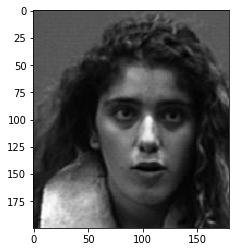

In [22]:
testshow()

This is the core class for the facial recognition software. It calculates the mean face, and then finds the shifted faces by subtracting the mean face from them, uses SVD to make the data a little more manageable, projects faces to this compression and then finds the faces that most closely resemble a selected face.

In [23]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """

    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        #Calculate the mean face by summing all the factial vectors and divide by k
        
        #Define F as the mn x k matrix whose columns are given my mean shifted face vectors
        
        self.F = get_faces(path)
        self.mu = np.mean(self.F, axis=1)
        self.Fbar = (self.F.T - self.mu).T
        Ul, V, D = la.svd(self.Fbar, full_matrices=False)
        self.U = Ul
        m,n = np.shape(self.F)
        self.n = n


    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        #Project an image onto the U to get an eigenface!
        return (self.U[:,0:s].T @ A).ravel()


    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        #Find the value of ghat
        ghat = self.U[:,0:s].T@(g - self.mu)
        index = 0
        closest = 99999999999999999999999999999999999
        #Check it against all of the other images
        for i in range(self.n):
            dif = self.project(self.Fbar[:,i],s)-ghat
            j = la.norm(dif)
            if j < closest:
                closest = j
                index = i
        return index
        


    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        #Try to match a picture to its nearest neighbor
        index = self.find_nearest(image, s)
        show(image)
        show(self.F[:,index])

In [24]:
def testFacial():
    #Make the object
    Faces = FacialRec()
    #Calculate the average face
    print(np.shape(Faces.mu))
    show(Faces.mu)
    
    print(np.shape(Faces.F[:,1]))
    show(Faces.F[:,1])
    print(np.shape(Faces.U))
    show(Faces.Fbar[:,1])
    show(Faces.U[:,50])
    
    #Projection
    

Here we see the work flow, the mean face, an original face, and then the mean shifted face.

mean face


original face


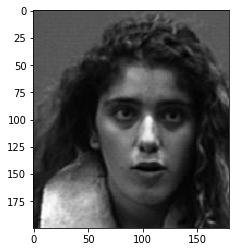

mean shifted face


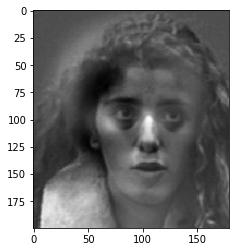

In [25]:
Faces = FacialRec() #Create the object
print("mean face") 
show(Faces.mu) #Display the mean face
print("original face")
show(Faces.F[:,1]) #Display an original face
print("mean shifted face")
show(Faces.Fbar[:,1]) #Display a mean shifted face

Here we look at a variety of eigen faces which are used as the principal components of facial recognitino for this algorithm.

Column 0


Column 20


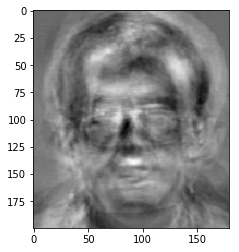

Column 40


Column 60


Column 100


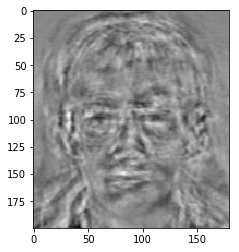

In [26]:
print("Column 0")
show(Faces.U[:,0]) 
print("Column 20")
show(Faces.U[:,20]) 
print("Column 40")
show(Faces.U[:,40]) 
print("Column 60")
show(Faces.U[:,60]) 
print("Column 100")
show(Faces.U[:,100]) 

Here we show how we can use the eigenfaces seen above to construct a face!

Original


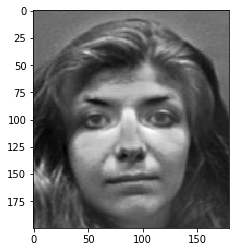

s=10


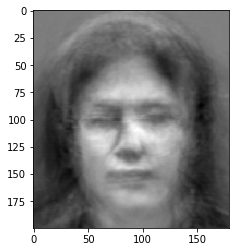

s=50


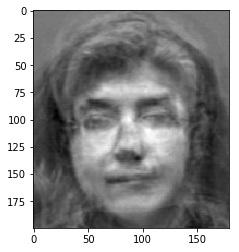

s=80


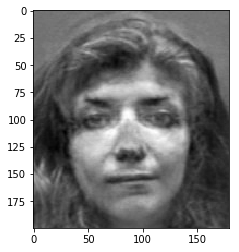

s=120


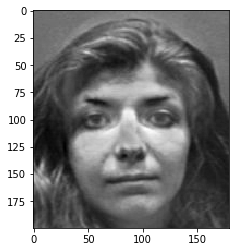

s=153


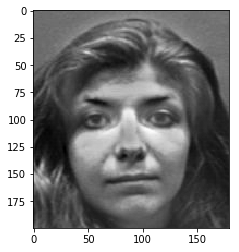

In [37]:
Faces = get_faces()
FaceRec = FacialRec()
Face = FaceRec.Fbar[:,5]
print("Original")
show(Face)
#print(np.shape(FaceRec.U[:,0:10]))
#print(np.shape(FaceRec.project(Face, 10)))
print("s=10")
show(FaceRec.U[:,0:10] @ FaceRec.project(Face, 10))
print("s=50")
show(FaceRec.U[:,0:50] @ FaceRec.project(Face, 50))
print("s=80")
show(FaceRec.U[:,0:80] @ FaceRec.project(Face, 80))
print("s=120")
show(FaceRec.U[:,0:120] @ FaceRec.project(Face, 120))
print("s=153")
show(FaceRec.U[:,0:153] @ FaceRec.project(Face, 153))

Finaly we are going to try and find faces that match a test image. Here the displayed faces are in pairs where the top face is matched to the face below.

In [32]:
def sample_faces(num_faces, path="./faces94"):
    # Get the list of possible images.
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg": # Only get jpg images.
                files.append(dirpath+"/"+fname)
    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, num_faces, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))


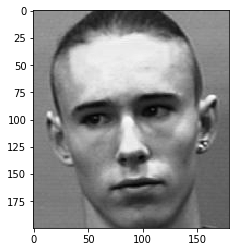

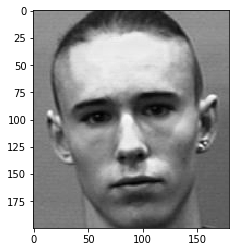

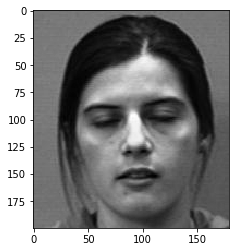

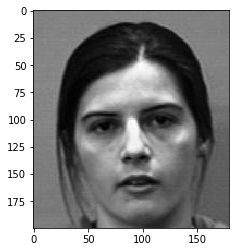

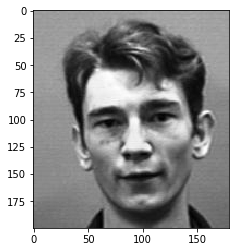

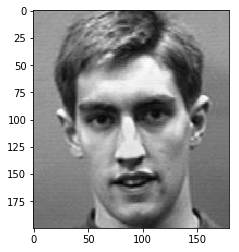

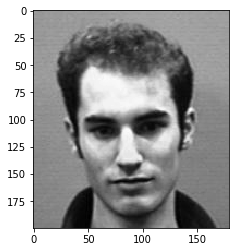

In [36]:
Facetest = FacialRec()
for test_image in sample_faces(7):
    #Test each of the images to see it it works!
    Facetest.match(test_image)